# Background Information

When an analyst determines the price of a house, they need to consider many predictors, including location, size, and construction quality. Luckily, machine learning models exist to do the work for them. In this project, I trained and evaluated regression models to predict the prices of houses. I used a dataset from OpenIntro of 2930 houses in Ames, Iowa with 79 predictors. To download the dataset and read the predictor descriptions, [click here](https://www.openintro.org/data/index.php?data=ames). 

# Import Libraries and Data

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Machine learning models
from sklearn.linear_model import LinearRegression

In [119]:
# Use the Order column (unique identifier for each house) as the row index
houses_data = pd.read_csv('ames_houses_data.csv', index_col="Order")
X = houses_data.drop(columns=["price"])
y = houses_data.loc[:, "price"]
print("X size: ", X.shape)

X size:  (2930, 80)


For simplicity, I only used countinuous, discrete, and ordinal predictors to train my models. Hence, I removed all of the nominal predictors from the dataset.

In [120]:
X = X.select_dtypes(include="number")

# Manually remove nominal columns encoded with integers
X.drop(columns=["MS.SubClass", "Mo.Sold", "PID"], inplace=True) 

print("X size after removing nominal predictors: ", X.shape)

X size after removing nominal predictors:  (2930, 34)


I then split the dataset into a training set (80%) and a test set (20%). 

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train size: ", X_train.shape)
print("X_test size: ", X_test.shape)

X_train size:  (2344, 34)
X_test size:  (586, 34)


# Training Set Procesesing

## Handling missing data

Regression models cannot be trained on data with missing values. Since model training works best with a lot of data, we cannot simply delete all the data points with missing values. Instead, we can replace missing data with a best guess based on other data in the dataset (data imputation). For simplicity, I will use the mean value of each predictor in the training set.

In [122]:
print("No. of missing values in X_train before imputation:", sum(X_train.isnull().sum()))
X_mean_imputer = SimpleImputer(strategy="mean")
X_mean_imputer.fit(X_train)
X_train = pd.DataFrame(X_mean_imputer.transform(X_train), 
                          columns=X_train.columns, 
                          index=X_train.index)
print("No. of missing values in X_train after imputation:", sum(X_train.isnull().sum()))

print("No. of missing values in X_test before imputation:", sum(X_test.isnull().sum()))
X_mean_imputer.fit(X_test)
X_test = pd.DataFrame(X_mean_imputer.transform(X_test), 
                          columns=X_test.columns, 
                          index=X_test.index)
print("No. of missing values in X_test after imputation:", sum(X_test.isnull().sum()))

No. of missing values in X_train before imputation: 542
No. of missing values in X_train after imputation: 0
No. of missing values in X_test before imputation: 140
No. of missing values in X_test after imputation: 0


In [123]:
print("No. of missing values in y_train:", y_train.isnull().sum())
print("No. of missing values in y_test:", y_test.isnull().sum())

No. of missing values in y_train: 0
No. of missing values in y_test: 0


# Exploratory Data Analysis

## Distribution of the target (house prices)

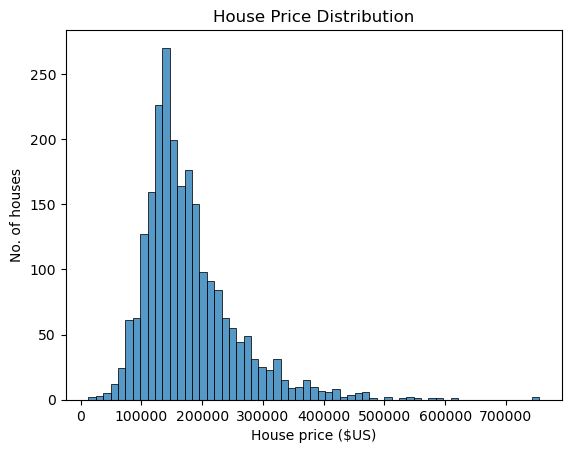

In [124]:
sns.histplot(y_train)
plt.title("House Price Distribution")
plt.xlabel("House price ($US)")
plt.ylabel("No. of houses")
plt.show()

In [125]:
#Distributions of all the predictors 
#train_data.hist(figsize=(15, 17))
#plt.show()

The distribution of house prices is positively skewed due to the presence of a few very expensive houses. 

## Correlations between variables

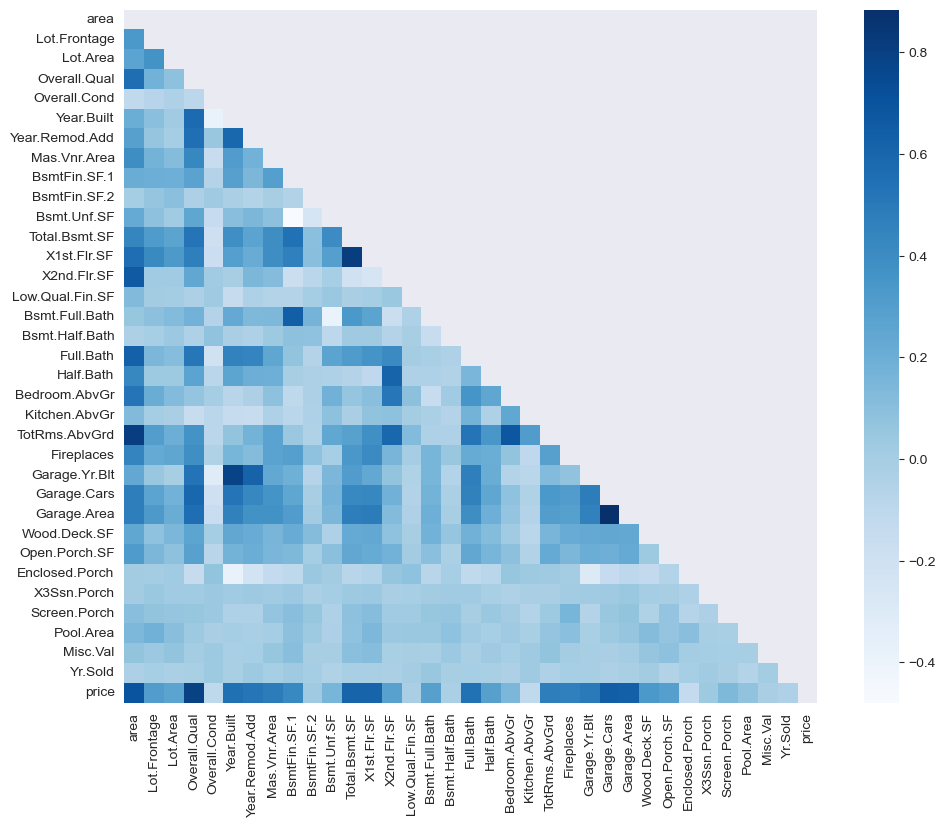

In [128]:
correlation_matrix = pd.concat([X_train, y_train], axis = 1).corr()
lower_triangle_mask = np.tril(np.ones(correlation_matrix.shape), k = -1).astype(bool)
# Replace all values above the lower triangle with NaN
correlation_matrix = correlation_matrix.where(lower_triangle_mask)

with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(12, 9))
    sns.heatmap(correlation_matrix, cmap="Blues", square=True); 
    plt.show()

### Correlations with the target (house price)

In [130]:
most_positive = correlation_matrix.loc["price"].sort_values(ascending=False)[0:5]
print(f"The {len(most_positive)} predictors that were most positively correlated with house price were:\n", 
      most_positive, "\n", sep="")

most_negative = correlation_matrix.loc["price"].sort_values(ascending=True)[0:1]
print(f"The predictor that was most negatively correlated with house price was:\n", 
       most_negative, sep="")

The 5 predictors that were most positively correlated with house price were:
Overall.Qual     0.795298
area             0.698315
Garage.Cars      0.644286
Garage.Area      0.633089
Total.Bsmt.SF    0.612038
Name: price, dtype: float64

The predictor that was most negatively correlated with house price was:
Enclosed.Porch   -0.130722
Name: price, dtype: float64


- **Overall.Qual**: Quality of the construction materials and workmanship on a scale of 1 to 10. 
- **area**: The total living area above the ground. 
- **Garage.Cars**: No. of cars that can fit in the garage. 
- **Total.Bsmt.SF**: The area of the basement.
- **Garage.Area**: Area of the garage. (Notice that is is highly correlated with GarageCars). 

There were no quantitative predictors that were significantly negatively correlated with the house price.

### Correlations between predictors

In [131]:
most_positive = correlation_matrix.stack().sort_values(ascending=False)[0:5]
print(f"The {len(most_positive)} predictor pairs that were most positively correlated were:\n", 
      most_positive, "\n", sep="")

most_negative = correlation_matrix.stack().sort_values(ascending=True)[0:1]
print(f"The predictor pair that was most negatively correlated was:\n", 
       most_negative, sep="")

The 5 predictor pairs that were most positively correlated were:
Garage.Area    Garage.Cars      0.883871
X1st.Flr.SF    Total.Bsmt.SF    0.813868
TotRms.AbvGrd  area             0.806434
price          Overall.Qual     0.795298
Garage.Yr.Blt  Year.Built       0.783982
dtype: float64

The predictor pair that was most negatively correlated was:
Bsmt.Unf.SF  BsmtFin.SF.1   -0.47883
dtype: float64


# Multiple Linear Regresssion

One of the simplest regression models we can use to predict the house prices is multiple linear regression.

**Major Assumptions of multiple linear regression**:
- **Linearity**: Assumes that the target is a linear combination of the predictors.
- **Absence of high leverage data points**: A high leverage data point is far away from the other data points in the predictor space and has a large influence on the regression fit. We removed high leverage data points earlier. 
- **Absence of collinearity between predictors**: Using collinear predictors to train a regression model increases the standard error of the returned sample regression coefficients (decreases the probability that they are close to the population regression coefficients). We will address this later using regularized regression models.

In [132]:
lr = LinearRegression().fit(X_train, y_train)
pred_y = lr.predict(X_test)

print("Training set R^2 score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set R^2 score: {:.2f}".format(lr.score(X_test, y_test)))

Training set score: 0.83
Test set score: 0.84


The $R^2$ score is the proportion of the variation in house prices that is explained by the model. 

Plot the residuals after fitting the model.

## Lasso Regression

Lasso regression regularizes the multiple linear regression model by constraining the magnitudes of the regression coefficients. This decreases overfitting. Machine learning models have hyperparameters, which control the values of the model parameters obtained through training. In this case, lasso regression contains one hyperparameter ($\lambda$), which controls the magnitudes of the obtained regression coefficients. 

The best set of hyperparameter values is determined by testing out a range of hyperparameter values and identifying the set that produces the best model. Since the test set is reserved for the evaluation of the final model, we will evaluate the models produced by different hyperparameter values using cross-validation.

In [ ]:
param_grid = {'lambda': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(, param_grid, cv=5)